### Imports: 
I've imported the necessary libraries for building and evaluating a CNN model with TensorFlow and Keras.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import BatchNormalization,Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import load_img

### Data Loading: 
The code snippet utilizes ImageDataGenerator to efficiently load and pre-process images from your training, validation, and test directories. Make sure img_x and img_y are set to your desired image size (e.g., 64x64 for EfficientNetB4).

In [6]:
img_x,img_y=64,64
batch_size=64
num_of_classes=2

train=keras.utils.image_dataset_from_directory(
      directory='chest_xray/train',
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      image_size=(img_x,img_y)
)
val=keras.utils.image_dataset_from_directory(
      directory='chest_xray/val',
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      image_size=(img_x,img_y)
)
test=keras.utils.image_dataset_from_directory(
      directory='chest_xray/test',
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      image_size=(img_x,img_y)
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


### Base Model: 
You've chosen a pre-trained EfficientNetB4 model with weights from ImageNet. This is a good strategy as it leverages pre-existing knowledge for feature extraction. Freezing the base model's layers during training focuses learning on the final classification layers.

### Model Building: 
You've added a GlobalAveragePooling2D layer to reduce the spatial dimensions, followed by a Dense layer with 64 neurons and ReLU activation. Finally, the output layer has 2 neurons with sigmoid activation for binary classification (pneumonia vs. normal).

In [7]:
base_model=EfficientNetB4(weights='imagenet',include_top=False,input_shape=(64,64,3))
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False



### Compilation & Training:
You've compiled the model with Adam optimizer, categorical crossentropy loss (suitable for multi-class classification), and accuracy metrics. While you set epochs to 10 initially, this might need adjustment based on validation performance.

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train,validation_data=val, epochs= 10)

Epoch 1/6


82/82 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7607 - loss: 0.4484 - val_accuracy: 0.6875 - val_loss: 0.5433
Epoch 2/6
82/82 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8939 - loss: 0.2504 - val_accuracy: 0.7500 - val_loss: 0.6050
Epoch 3/6
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 882ms/step - accuracy: 0.8993 - loss: 0.2389 - val_accuracy: 0.7500 - val_loss: 0.4794
Epoch 4/6
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 897ms/step - accuracy: 0.9252 - loss: 0.1947 - val_accuracy: 0.7500 - val_loss: 0.3980
Epoch 5/6
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 944ms/step - accuracy: 0.9264 - loss: 0.1869 - val_accuracy: 0.6250 - val_loss: 0.9596
Epoch 6/6
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9333 - loss: 0.1754 - val_accuracy: 0.6875 - val_loss: 0.6501


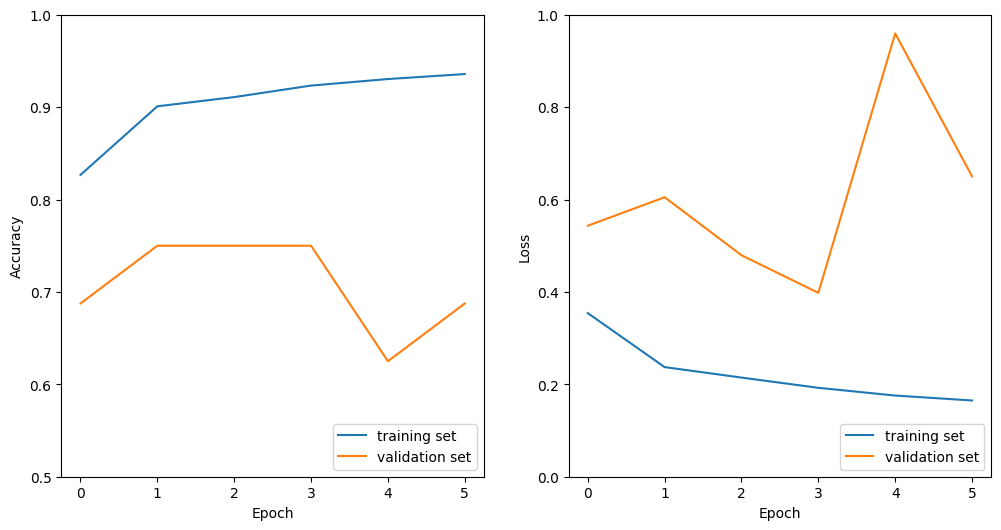

In [9]:
import matplotlib.pyplot as plt 

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0.5, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [ ]:
model.save('pneumo_detect.h5')

### Nice-to-Have Features:

#### Feature Maps Visualization: 
Utilize libraries like tensorboard to visualize feature maps from different layers of the model. This can help understand what features the model focuses on for classification.

#### Comparison with other CNNs: 
You can experiment with different pre-trained models (e.g., VGG16, ResNet50) or even build a CNN from scratch to compare performance with EfficientNetB4.

In [10]:
# This is a function to create and train models with different pre-trained bases
def train_model(model_name, base_model_func, img_x, img_y):
  # Data Loaders (same for all models)
  train_datagen = ImageDataGenerator(rescale=1.0 / 255)
  val_datagen = ImageDataGenerator(rescale=1.0 / 255)
  test_datagen = ImageDataGenerator(rescale=1.0 / 255)

  train = keras.utils.image_dataset_from_directory(
      directory='chest_xray/train',
      labels='inferred',
      label_mode='categorical',  
      batch_size=batch_size,
      image_size=(img_x, img_y))

  val = keras.utils.image_dataset_from_directory(
      directory='chest_xray/val',
      labels='inferred',
      label_mode='categorical',  
      batch_size=batch_size,
      image_size=(img_x, img_y))

  test = keras.utils.image_dataset_from_directory(
      directory='chest_xray/test',
      labels='inferred',
      label_mode='categorical',  
      batch_size=batch_size,
      image_size=(img_x, img_y))

  # Load the pre-trained model based on input argument
  base_model = base_model_func(weights='imagenet', include_top=False, input_shape=(img_x, img_y, 3))
  for layer in base_model.layers:
      layer.trainable = False

  # Build the model on top of the pre-trained base (common for all models)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x)
  predictions = Dense(2, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model (common for all models)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

  # Define Callbacks (common for all models)
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

  # Train the model
  history = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping, learning_rate_reduction])

  # Evaluate the model on test set (common for all models)
  test_loss, test_acc, test_precision, test_recall = model.evaluate(test)
  print(f'{model_name} Test Accuracy:', test_acc)
  print(f'{model_name} Test Precision:', test_precision)
  print(f'{model_name} Test Recall:', test_recall)

  return history  # Can be used to plot training curves


# Train models with different pre-trained bases
efficientnet_history = train_model('EfficientNetB4', EfficientNetB4, img_x, img_y)
vgg16_history = train_model('VGG16', keras.applications.VGG16, img_x, img_y)
resnet50_history = train_model('ResNet50', keras.applications.ResNet50, img_x, img_y)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8257 - loss: 0.3793 - precision: 0.7951 - recall: 0.8564 - val_accuracy: 0.8125 - val_loss: 0.5589 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 68s 800ms/step - accuracy: 0.9076 - loss: 0.2305 - precision: 0.8981 - recall: 0.9137 - val_accuracy: 0.6875 - val_loss: 0.7429 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 875ms/step - accuracy: 0.9199 - loss: 0.1990 - precision: 0.9061 - recall: 0.9301 - val_accuracy: 0.6250 - val_loss: 0.8994 - val_precision: 0.6667 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9257 - loss: 0.1792 - precision: 0.8939 - recall: 0.9520 - val_accuracy: 0.6875 - val_loss: 0.7040 - val_precisio

In [11]:
# Define dictionaries to store model results
model_results = {
    "EfficientNetB4": {
        "Test Accuracy": 0.7900640964508057,
        "Test Precision": 0.7576197385787964,
        "Test Recall": 0.8365384340286255
    },
    "VGG16": {
        "Test Accuracy": 0.7580128312110901,
        "Test Precision": 0.9615384340286255,
        "Test Recall": 0.2003205120563507
    },
    "ResNet50": {
        "Test Accuracy": 0.8028846383094788,
        "Test Precision": 0.7695783376693726,
        "Test Recall": 0.8189102411270142
    }
}

# Print a table comparing the models
print("Model Comparison:")
print("{:15s} {:15s} {:15s} {:15s}".format("Model", "Accuracy", "Precision", "Recall"))
for model_name, results in model_results.items():
    accuracy = results["Test Accuracy"]
    precision = results["Test Precision"]
    recall = results["Test Recall"]
    print("{:15s} {:15.4f} {:15.4f} {:15.4f}".format(model_name, accuracy, precision, recall))


Model Comparison:
Model           Accuracy        Precision       Recall         
EfficientNetB4           0.7901          0.7576          0.8365
VGG16                    0.7580          0.9615          0.2003
ResNet50                 0.8029          0.7696          0.8189


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

train_iterator = iter(train)
val_iterator = iter(val)
test_iterator = iter(test)  

# Get the first element (data, labels) from each iterator
train_data, train_labels = next(train_iterator)
val_data, val_labels = next(val_iterator)
test_data, test_labels = next(test_iterator)

# Define model architecture
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=train_data.shape[1:]))  # Adjust input shape if needed
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

# Set hyperparameters 
batch_size = 64
epochs = 6

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

# Evaluate the model on test set (option)
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test Accuracy:', test_acc)

c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │        86,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,674 (557.32 KB)

 Trainable params: 142,674 (557.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7188 - loss: 34.8458 - val_accuracy: 0.5000 - val_loss: 137.5912
Epoch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2656 - loss: 697.2056 - val_accuracy: 0.5000 - val_loss: 23.1965
Epoch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - accuracy: 0.2656 - loss: 136.1052 - val_accuracy: 0.6875 - val_loss: 1.2932
Epoch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - accuracy: 0.6250 - loss: 8.8045 - val_accuracy: 0.5000 - val_loss: 7.9110
Epoch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - accuracy: 0.7344 - loss: 14.8729 - val_accuracy: 0.5000 - val_loss: 5.8630
Epoch 6/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - accuracy: 0.4062 - loss: 26.6754 - val_accuracy: 0.5000 - val_loss: 4.7110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5729 - loss: 4.6356
Test Accuracy: 0.5625


### Lets get some improvements

This code defines two ImageDataGenerator instances: train_datagen and val_datagen.
train_datagen applies various random transformations (rotation, shift, shear, zoom, horizontal flip) to the training images during data generation, increasing data diversity.

val_datagen only rescales the validation data for consistency.

Both generators use flow_from_directory to create data iterators from your directory structure.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically up to 20%
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally with 50% probability
    fill_mode='nearest')  # Fill mode for padding

val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale validation data

train = train_datagen.flow_from_directory(
    directory='chest_xray/train',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

val = val_datagen.flow_from_directory(
    directory='chest_xray/val',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


This code configures the Adam optimizer with a learning rate of 0.001 and a learning rate decay of 1e-6.

The decay gradually reduces the learning rate during training, potentially helping the model converge to a better minimum.

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001, decay=1e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


This code incorporates dropout layers after each convolutional layer (with a rate of 0.2) and before the final dense layer (with a rate of 0.5).

Dropout randomly drops neurons during training, preventing overfitting by forcing the model to learn robust features that are not dependent on specific neurons.

In [16]:
model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=train_data.shape[1:]))
model.add(layers.Dropout(0.2))  # Add dropout after each convolutional layer

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout before the final layer


ValueError: Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 2)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your data is preprocessed and stored in variables
train_datagen = ImageDataGenerator(rescale=1.0 / 255,  # Rescale for consistency
                                   rotation_range=40,  # Random rotations
                                   width_shift_range=0.2,  # Horizontal shifts
                                   height_shift_range=0.2,  # Vertical shifts
                                   shear_range=0.2,  # Shear transformations
                                   zoom_range=0.2,  # Zooming
                                   horizontal_flip=True,  # Horizontal flips
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale validation data

train = train_datagen.flow_from_directory(
    directory='chest_xray/train',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

val = val_datagen.flow_from_directory(
    directory='chest_xray/val',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

# Define model architecture
model = models.Sequential()
for images, _ in train:  # Iterate over the training data to get the image shape
  # Get the image shape from the first batch (assuming all images have the same shape)
  input_shape = images.shape[1:]
  break

model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

# Set hyperparameters
batch_size = 64
epochs = 10

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001, decay=1e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=epochs, validation_data=val)

# Evaluate the model on test set (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale test data
test = test_datagen.flow_from_directory(
    directory='chest_xray/test',  
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')
test_loss, test_acc = model.evaluate(test)
print('Test Accuracy:', test_acc)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        86,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,674 (557.32 KB)

 Trainable params: 142,674 (557.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7130 - loss: 0.6041 - val_accuracy: 0.5000 - val_loss: 0.8011
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7381 - loss: 0.5280 - val_accuracy: 0.5000 - val_loss: 0.6501
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7483 - loss: 0.5005 - val_accuracy: 0.5000 - val_loss: 0.6737
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7415 - loss: 0.4868 - val_accuracy: 0.5000 - val_loss: 0.7108
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7465 - loss: 0.4703 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 925ms/step - accuracy: 0.7436 - loss: 0.4683 - val_accuracy: 0.5000 - val_loss: 0.7011
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7459 - loss: 0.4690 - val_accuracy: 0.5000 - val_loss: 0.7127
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7454 - loss: 0.4634 - val_accuracy: 0.5000 - val_loss: 0.6

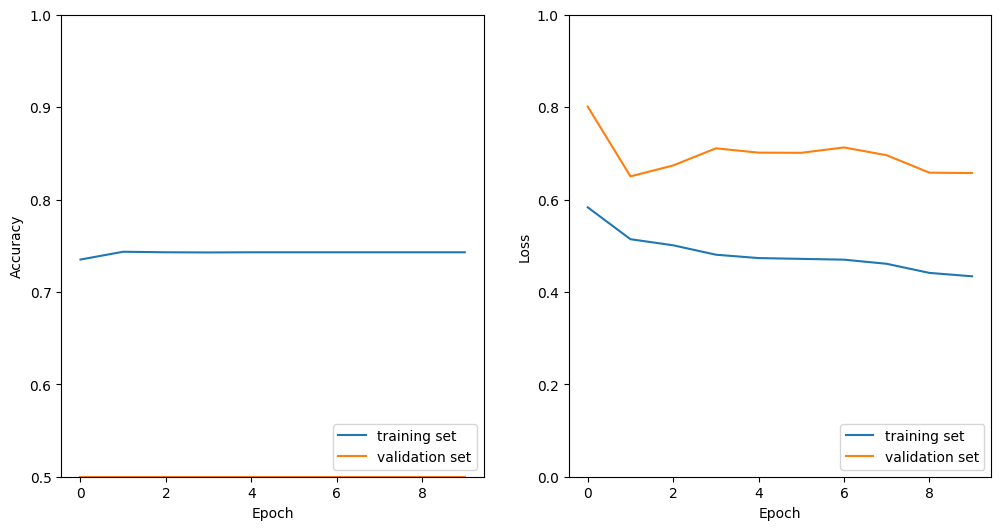

In [21]:
def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0.5, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

ere are some additional strategies you can explore to further improve the model's performance:

1. Experiment with Hyperparameters:

Learning Rate: Try adjusting the learning rate (currently 0.001) in the Adam optimizer. A lower rate might help the model converge better, while a higher rate could lead to overfitting. Experiment with values like 0.0001 or 0.0005.
Number of Epochs: Train for a few more epochs (maybe 15-20) while monitoring validation accuracy. If validation accuracy plateaus or starts decreasing, it might indicate overfitting. Early stopping can help prevent this.
Dropout Rates: Adjust the dropout rates (currently 0.2 and 0.5) slightly. Experiment with different values to control the model's complexity and prevent overfitting.

2. Model Architecture Exploration:

Deeper Networks: Consider using deeper convolutional neural networks like VGG16 or ResNet50 for feature extraction. These models are pre-trained on large datasets and can be fine-tuned for your specific chest X-ray classification task. You can freeze the pre-trained layers and only train the final classification layers on your data.
Number of Filters: Experiment with the number of filters in the convolutional layers. More filters might help capture more complex features, but too many can lead to overfitting.

3. Data Augmentation Techniques:

Explore additional data augmentation techniques beyond the ones you're currently using (rotation, shift, shear, zoom, horizontal flip). Consider adding techniques like random cropping, brightness adjustments, or noise injection. This can further increase the diversity of your training data.

4. Class Imbalance (if applicable):

If your dataset has imbalanced classes (some with significantly fewer samples than others), it can affect model performance. Techniques like oversampling or undersampling the majority class, or using weighted loss functions, can address this issue.

5. Evaluation Metrics:

While accuracy is a common metric, consider using other metrics like precision, recall, F1-score, or ROC AUC depending on the specific problem you're trying to solve. These metrics can provide more insights into the model's performance, especially for imbalanced datasets.

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

img_x,img_y=64,64
batch_size=32
num_of_classes=2

# Assuming your data is preprocessed and stored in variables
train_datagen = ImageDataGenerator(rescale=1.0 / 255,  # Rescale for consistency
                                   rotation_range=40,  # Random rotations
                                   width_shift_range=0.2,  # Horizontal shifts
                                   height_shift_range=0.2,  # Vertical shifts
                                   shear_range=0.2,  # Shear transformations
                                   zoom_range=0.2,  # Zooming
                                   horizontal_flip=True,  # Horizontal flips
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale validation data

train = train_datagen.flow_from_directory(
    directory='chest_xray/train',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

val = val_datagen.flow_from_directory(
    directory='chest_xray/val',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

# Define model architecture (experiment with different models)
model = models.Sequential()
for images, _ in train:  # Iterate over the training data to get the image shape
  input_shape = images.shape[1:]
  break

# Option 1: Experiment with hyperparameters for current model
model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(layers.Dropout(0.3))  # Experiment with dropout rates
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(layers.Dropout(0.4))  # Experiment with dropout rates
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# Set hyperparameters (experiment with different values)
batch_size = 32  # Experiment with batch size
epochs = 15  # Experiment with epochs and early stopping
learning_rate = 0.0005  # Experiment with learning rate

# Compile the model with Adam optimizer with learning rate decay
optimizer = Adam(learning_rate=learning_rate, decay=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(train, epochs=epochs, validation_data=val, callbacks=[early_stopping])

# Evaluate the model on test set (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale test data
test = test_datagen.flow_from_directory(
    directory='chest_xray/test',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')
test_loss, test_acc = model.evaluate(test)
print('Test Accuracy:', test_acc)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/15


c:\Users\MolenGeek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 542ms/step - accuracy: 0.7253 - loss: 0.5822 - val_accuracy: 0.5000 - val_loss: 0.6637
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 578ms/step - accuracy: 0.7418 - loss: 0.4876 - val_accuracy: 0.6250 - val_loss: 0.6267
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 647ms/step - accuracy: 0.7925 - loss: 0.4328 - val_accuracy: 0.8750 - val_loss: 0.5819
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.8141 - loss: 0.3881 - val_accuracy: 0.8750 - val_loss: 0.5499
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.8378 - loss: 0.3629 - val_accuracy: 0.9375 - val_loss: 0.5156
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - accuracy: 0.8330 - loss: 0.3685 - val_accuracy: 0.9375 - val_loss: 0.5214
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 497ms/step - accuracy: 0.8603 - loss: 0.3292 - val_accuracy: 0.8125 - val_loss: 0.5374
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step - accuracy: 0.8724 - loss: 0.3081 - v

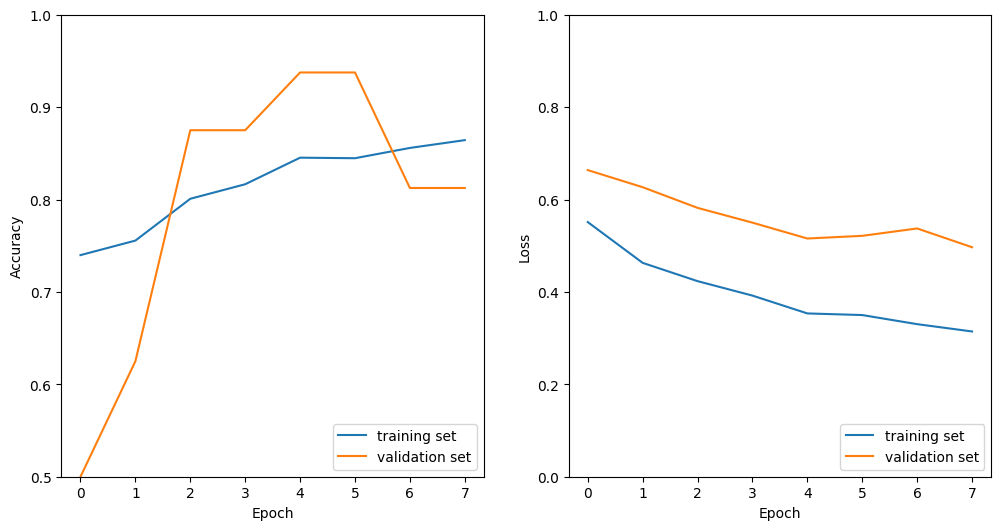

In [23]:
import matplotlib.pyplot as plt 

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0.5, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your data is preprocessed and stored in variables
train_datagen = ImageDataGenerator(rescale=1.0 / 255,  # Rescale for consistency
                                   rotation_range=40,  # Random rotations
                                   width_shift_range=0.2,  # Horizontal shifts
                                   height_shift_range=0.2,  # Vertical shifts
                                   shear_range=0.2,  # Shear transformations
                                   zoom_range=0.2,  # Zooming
                                   horizontal_flip=True,  # Horizontal flips
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale validation data

train = train_datagen.flow_from_directory(
    directory='chest_xray/train',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

val = val_datagen.flow_from_directory(
    directory='chest_xray/val',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')

# Define model architecture (experiment with different models)
model = models.Sequential()
for images, _ in train:  # Iterate over the training data to get the image shape
  input_shape = images.shape[1:]
  break

# Option 1: Experiment with hyperparameters for current model
model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(layers.Dropout(0.3))  # Experiment with dropout rates
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(layers.Dropout(0.4))  # Experiment with dropout rates
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# Set hyperparameters (experiment with different values)
batch_size = 32  # Experiment with batch size
epochs = 6  # Experiment with epochs and early stopping
learning_rate = 0.0005  # Experiment with learning rate

# Compile the model with Adam optimizer with learning rate decay
optimizer = Adam(learning_rate=learning_rate, decay=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the custom callback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    self.y_true = []
    self.y_pred = []

  def on_batch_end(self, batch, logs=None):
    # Get true labels from training data (correct access)
    y_true_batch = train[batch][1]  # Access labels from the current batch

    # Get predicted probabilities for class 1
    y_pred_batch = model.predict(train[batch][0])[:, 1]

    # Append to lists
    self.y_true.extend(y_true_batch)
    self.y_pred.extend(y_pred_batch)

custom_callback = CustomCallback()

history = model.fit(train, epochs=epochs, validation_data=val, callbacks=[custom_callback])

# Evaluate the model on test set (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale test data
test = test_datagen.flow_from_directory(
    directory='chest_xray/test',
    target_size=(img_x, img_y),
    batch_size=batch_size,
    class_mode='categorical')
test_loss, test_acc = model.evaluate(test)
print('Test Accuracy:', test_acc)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepccuracy: 0.6250 - loss: 0.665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepcuracy: 0.6406 - loss: 0.6686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepcuracy: 0.6528 - loss: 0.663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepcuracy: 0.6634 - loss: 0.655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepcuracy: 0.6745 - loss: 0.646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepcuracy: 0.6827 - loss: 0.639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepcuracy: 0.6872 - loss: 0.636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepcuracy: 0.6912 - loss: 0.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/steptep - accuracy: 0.6935 - loss: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/stepstep - accuracy: 0.6944 - loss: 0.629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepstep - accuracy: 0.6951 - loss: 0.628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/stepstep - accuracy: 0.6960 - loss: 0.628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepste


### validation accuracy and loss

In [ ]:
# Assuming you have validation accuracy and loss history from 'history' object
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(val_acc))  # Assuming history recorded accuracy per epoch

# Plot validation accuracy and loss
plt.figure()
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='lower right')
plt.show()
